In [2]:
from PPO_train_test import PPO_train, PPO_train_udr, PPO_train_adr, PPO_test

TIMESTEPS = 1_500_000
SEED = 42

We want to deploy our agent in the real world that is represented by the Target environment, but we have only access to a simulator (source environment) which has a sistematic error wrt real word.

Since we want to close this sim2real gap we will experiment some techniques to address this problem.

To begin with, we will try a simple UDR. Then our focus will be implementing an ADR technique inspired to the OpenAI original paper where ADR is formally introduced in the RL world.

In the following experiments PPO, a policy-based RL algorithm, will be employed.

# Hopper Environment

Nota:
- In Target, l'hopper ha un torso più pesante. La massa elevata conferisce inerzia. L'inerzia agisce come un "filtro passa-basso" naturale: smorza le oscillazioni e rende il robot più stabile contro piccoli errori di controllo o rumore nelle azioni.

- In Source, l'hopper ha un torso molto più leggero. Con meno inerzia, il robot diventa "nervoso" (twitchy). Ogni piccola forza applicata dai motori si traduce in un'accelerazione angolare molto più rapida (F=m⋅a→a=F/m; se m scende, a sale). Questo rende molto più facile per il robot perdere l'equilibrio e cadere (terminando l'episodio prima dei 500 step).

I motori (attuatori) dell'Hopper hanno la stessa forza massima in entrambi gli ambienti, ma nel Source devono spingere meno massa.
Nel caso Source, il robot è "sovra-potenziato" rispetto al suo peso. Questo rende il paesaggio di ottimizzazione (la "superficie" che l'algoritmo PPO deve scalare) molto più frastagliato. Un'azione leggermente sbagliata nel Source porta a conseguenze catastrofiche (caduta) molto più velocemente che nel Target.
L'ambiente Hopper-v* standard di Gym (che corrisponde al tuo Target) è stato progettato e sintonizzato dai creatori di MuJoCo per avere proprietà fisiche che rendono la locomozione apprendibile e stabile. Modificando arbitrariamente una massa fondamentale come quella del torso (togliendo 1kg, che è una percentuale significativa del peso totale), si crea un robot "sbilanciato" o fisicamente meno adatto alla locomozione rispetto al design originale.

Per questo motivo, mentre target->target arriva sempre a 500 timesteps medi (con std=0) per episodio in test, source->source non ci riesce mai.

Training on SOURCE

In [ ]:
PPO_train(
    train_env_id='CustomHopper-source-v0',
    model_name=f'hopper_source_{SEED}',
    lr=3e-4,
    steps=TIMESTEPS,
    seed=SEED
)


--- Training on CustomHopper-source-v0 ---


Output()

KeyboardInterrupt: 

SOURCE -> SOURCE

In [28]:
mean, std = PPO_test(
    test_env_id='CustomHopper-source-v0',
    model_name=f'hopper_source_{SEED}'
)

--- Testing on CustomHopper-source-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 1710.56 +/- 6.91
  Mean Steps:  500.00 +/- 0.00


SOURCE -> TARGET

In [30]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'hopper_source_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---
Test Results:
  Mean Reward: 1147.30 +/- 67.66
  Mean Steps:  296.36 +/- 13.30


Training on TARGET

Output()


--- Training on CustomHopper-target-v0 ---


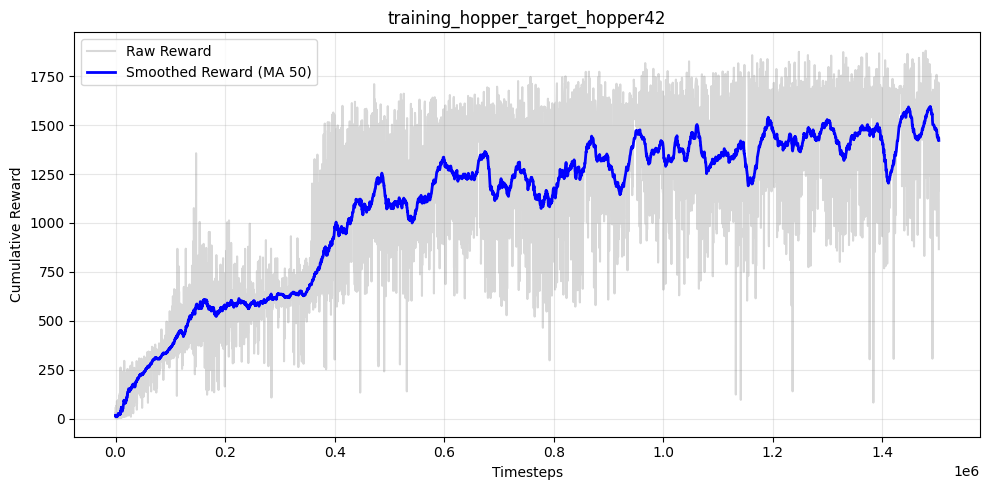

In [ ]:
PPO_train(
    train_env_id='CustomHopper-target-v0',
    model_name=f'hopper_target_{SEED}',
    lr=3e-4,
    steps=TIMESTEPS,
    seed=SEED
)

TARGET -> TARGET

In [33]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'hopper_target_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 1675.13 +/- 20.69
  Mean Steps:  500.00 +/- 0.00


## UDR

In [ ]:
model_name=f'hopper_source_udr_constant_50_medium_{SEED}'

Output()


--- Training on CustomHopper-source-v0 using UDR ---


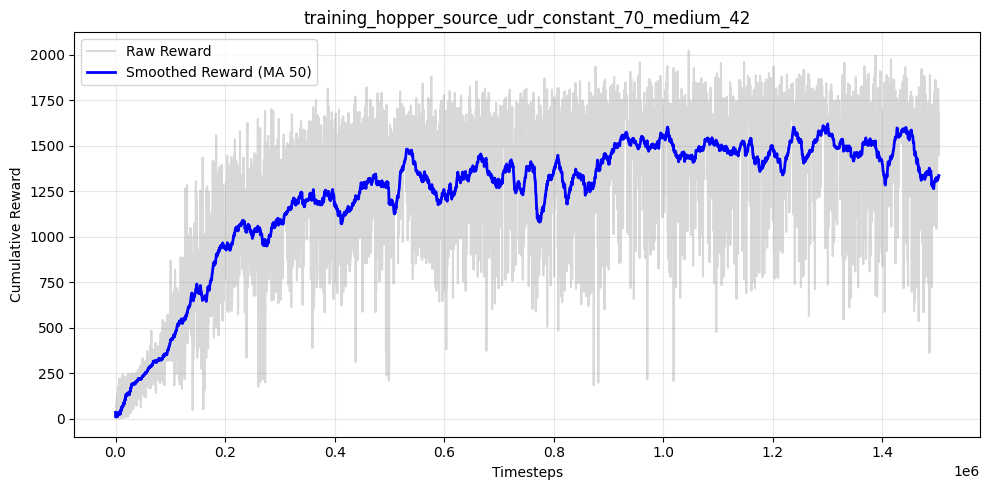

In [35]:
PPO_train_udr(
    train_env_id='CustomHopper-source-v0',
    model_name=model_name,
    lr=3e-4,
    lr_scheduler_type='constant',
    steps=TIMESTEPS,
    udr_range=0.5,
    net_size="medium", # [ small - medium - large ] -> [ 64 - 128 - 256 ]
    seed=SEED
)

In [36]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=model_name
)

--- Testing on CustomHopper-target-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 1321.64 +/- 125.75
  Mean Steps:  357.22 +/- 34.30


## ADR (OpenAI Style)

In [37]:
model_name = f'hopper_source_adr_constant_70_1300_40000_medium_{SEED}'

Output()


--- Training on CustomHopper-source-v0 using ADR ---


[ADR Boundary Test] Range +/- 5.0% -> Reward: 294.28 +/- 1.3930836871917436

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 422.25 +/- 31.771588687430487

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 789.24 +/- 18.184191050510197

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1133.39 +/- 73.39047347362732

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1099.84 +/- 49.97575507249878

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1169.94 +/- 214.4253899442138

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1038.51 +/- 54.157283543459336

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1054.94 +/- 36.98030588720697

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1249.20 +/- 74.85557807207793

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1486.08 +/- 54.23532378401383

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1612.14 +/- 75.97543782553616

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1421.05 +/- 304.5797342449694

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1552.20 +/- 96.11240369717305

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1351.58 +/- 349.05583902024347

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1471.51 +/- 329.00429370596856

[ADR Boundary Increased] New Range +/- 35.0%

[ADR Boundary Test] Range +/- 35.0% -> Reward: 1315.05 +/- 301.438652976177

[ADR Boundary Increased] New Range +/- 40.0%

[ADR Boundary Test] Range +/- 40.0% -> Reward: 1392.04 +/- 290.86794123602505

[ADR Boundary Increased] New Range +/- 45.0%

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1185.28 +/- 332.9855651296013

[ADR Boundary Test] Range +/- 45.0% -> Reward: 1420.67 +/- 321.4829507475548

[ADR Boundary Increased] New Range +/- 50.0%

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1617.10 +/- 238.8512323929348

[ADR Objective Boundary Reached] New Range +/- 50.0%

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1554.20 +/- 293.66963545000795

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1294.80 +/- 346.47084508559294

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1400.14 +/- 384.2378656378278

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1062.06 +/- 466.93625021044846

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1372.97 +/- 432.4532329838663

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1245.37 +/- 471.94276256108105

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1201.30 +/- 372.99060754259466

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1133.49 +/- 240.32048548795305

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1465.44 +/- 418.23130326819125

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1385.94 +/- 392.2620266933875

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1498.91 +/- 331.37759045219013

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1581.18 +/- 259.48066274710305

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1680.71 +/- 116.03891712961352

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1426.32 +/- 288.42920374076795

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1629.65 +/- 295.7906078733279

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1520.97 +/- 310.87534359154097

[ADR Boundary Test] Range +/- 50.0% -> Reward: 1198.39 +/- 500.179517895554

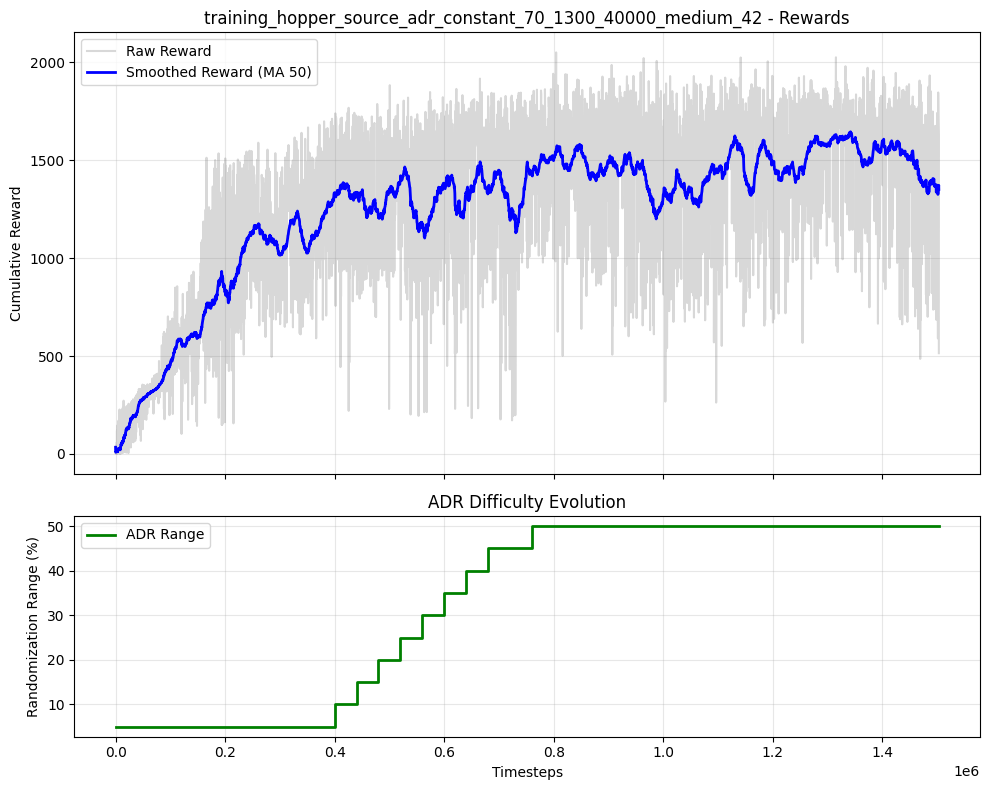

In [ ]:
PPO_train_adr(
    train_env_id='CustomHopper-source-v0',
    model_name=model_name,
    lr=3e-4,
    lr_scheduler_type="constant",
    steps=TIMESTEPS,
    starting_adr_range=0.05,
    objective_adr_range=0.5,
    increase_rate=0.05,
    reward_to_check=1300,
    check_frequency=40_000,
    net_size="medium",
    seed=SEED
)

In [39]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=model_name
)

--- Testing on CustomHopper-target-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 743.10 +/- 9.98
  Mean Steps:  214.56 +/- 1.98


## Hopper Visualization

In [ ]:
from utils.visualize_agent import visualize

visualize(
    model_path=f"models/{model_name}",
    env_id="CustomHopper-target-v0"
)

# Walker2D Environment

Training on SOURCE


--- Training on CustomWalker-source-v0 ---


Output()

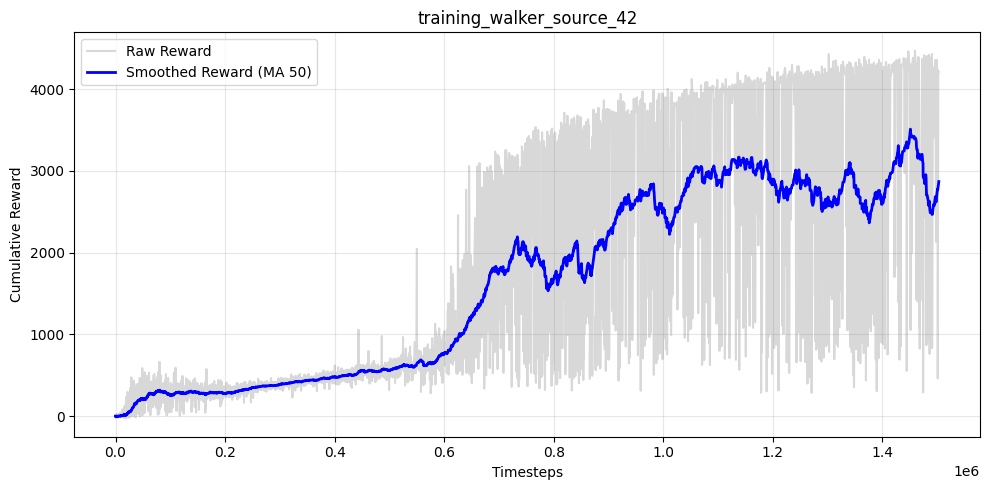

In [3]:
PPO_train(
    train_env_id='CustomWalker-source-v0',
    model_name=f'walker_source_{SEED}',
    lr=3e-4,
    steps=TIMESTEPS,
    seed=SEED
)

SOURCE -> SOURCE

In [4]:
mean, std = PPO_test(
    test_env_id='CustomWalker-source-v0',
    model_name=f'walker_source_{SEED}'
)

--- Testing on CustomWalker-source-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 4167.98 +/- 897.56
  Mean Steps:  951.36 +/- 191.18


SOURCE -> TARGET

In [ ]:
mean, std = PPO_test(
    test_env_id='CustomWalker-target-v0',
    model_name=f'walker_source_{SEED}'
)

Training on TARGET

In [ ]:
PPO_train(
    train_env_id='CustomWalker-target-v0',
    model_name=f'walker_target_{SEED}',
    lr=3e-4,
    steps=TIMESTEPS,
    seed=SEED
)

TARGET -> TARGET

In [ ]:
mean, std = PPO_test(
    test_env_id='CustomWalker-target-v0',
    model_name=f'walker_target_{SEED}'
)

## UDR

In [ ]:
model_name=f'walker_source_udr_constant_50_medium_{SEED}'

In [ ]:
PPO_train_udr(
    train_env_id='CustomWalker-source-v0',
    model_name=model_name,
    lr=3e-4,
    lr_scheduler_type='constant',
    steps=TIMESTEPS,
    udr_range=0.5,
    net_size="medium", # [ small - medium - large ] -> [ 64 - 128 - 256 ]
    seed=SEED
)

In [ ]:
mean, std = PPO_test(
    test_env_id='CustomWalker-target-v0',
    model_name=model_name
)

## ADR (OpenAI Style)

In [ ]:
model_name = f'ppo_source_adr_constant_50_1300_40000_medium_{SEED}'

In [ ]:
PPO_train_adr(
    train_env_id='CustomWalker-source-v0',
    model_name=model_name,
    lr=3e-4,
    lr_scheduler_type="constant",
    steps=TIMESTEPS,
    starting_adr_range=0.05,
    objective_adr_range=0.5,
    increase_rate=0.05,
    reward_to_check=1300,
    check_frequency=40_000,
    net_size="medium",
    seed=SEED
)

In [ ]:
mean, std = PPO_test(
    test_env_id='CustomWalker-target-v0',
    model_name=model_name
)

## Walker Visualization

In [6]:
from utils.visualize_agent import visualize

model_name = f"walker_source_{SEED}"

visualize(
    model_path=f"models/{model_name}",
    env_id="CustomWalker-target-v0"
)

Caricamento modello da: models/walker_source_42
Visualizzazione su ambiente: CustomWalker-target-v0
--- Episodio 1 ---
Reward Totale: 948.11
--- Episodio 2 ---
Reward Totale: 1106.84
--- Episodio 3 ---
Reward Totale: 1081.08
--- Episodio 4 ---
Reward Totale: 1133.72
--- Episodio 5 ---
Reward Totale: 1244.72
